In [1]:
import wrf
import cartopy.crs as ccrs
import netCDF4 as nc
import glob
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pyart
import zipfile
import datetime as dt
import os
import pandas as pd

def plot_radar(rid, time, lon, lat, ax, sweep=1, plot_cbar=False, cax=[0.2,0.08,0.6,0.01]):
    
    radar = load_radar(rid, time)
    disp=pyart.graph.GridMapDisplay(radar)
    if rid=="2":
        min_lon=143; max_lon=146; min_lat=-39.5; max_lat=-36.5
    if rid=="68":
        min_lon=145; max_lon=148; min_lat=-39.5; max_lat=-36.5        
    elif rid=="40":
        min_lon=147; max_lon=151; min_lat=-36.5; max_lat=-33.5
    elif rid=="71":
        min_lon=149; max_lon=152; min_lat=-35; max_lat=-32
    elif rid=="56":
        min_lon=142; max_lon=145; min_lat=-24; max_lat=-21
    elif rid=="8":
        min_lon=151; max_lon=154; min_lat=-27.5; max_lat=-24.5
    elif rid=="50":
        min_lon=151; max_lon=154; min_lat=-29; max_lat=-26
    elif rid=="66":
        min_lon=150; max_lon=155; min_lat=-29; max_lat=-25
    x,y = radar.get_point_longitude_latitude()
    c=ax.pcolormesh(x, y, np.nanmax(radar.fields["corrected_reflectivity"]["data"],axis=0),
                   cmap=pyart.graph.cm_colorblind.HomeyerRainbow, vmin=0, vmax=60)
    ax.set_ylim([min_lat, max_lat])
    ax.set_xlim([min_lon, max_lon])
    ax.plot(lon, lat, marker="x", mew=2, ms=12, color="k")
    if plot_cbar:
        cb=plt.colorbar(c, cax=plt.axes(cax), orientation="horizontal", extend="both")
        cb.set_label("Reflectivity (DBZ)")
    return disp
    
def unpack_level1b(rid, times):
        #Unzip level1b data between times[0] and times[1], and save to scratch
        assert times[0].year == times[1].year, "Times range must be within calendar year"
        files = np.array(glob.glob("/g/data/rq0/admin/level_1b_v2/"+rid+"/grid/"+str(times[0].year)+"/*.zip"))
        if len(files) == 0:
                print("NO FILES FOUND FOR RID: ")#+rid+" AND TIMES "+times[0]+" "+times[-1])
        file_dates = np.array([dt.datetime.strptime(f.split("/")[9].split("_")[1], "%Y%m%d") for f in files])
        target_files = files[(file_dates >= times[0].replace(hour=0, minute=0)) & (file_dates <= times[1].replace(hour=0, minute=0))]
        extract_to = "/scratch/eg3/ab4502/tint/"
        for f in target_files:
                with zipfile.ZipFile(f, "r") as zip_ref:
                        zip_ref.extractall(extract_to)    
    
def load_radar(rid, time, radar_t_delta=0):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    

    #Unpack gridded radar files. Create empty files based on missing files reported in Level 2
    times = [time+dt.timedelta(seconds=-60*6), time]
    unpack_level1b(rid, times)
    grid_files = np.sort(glob.glob("/scratch/eg3/ab4502/tint/"+rid+"*_grid.nc"))
    file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                    "%Y%m%d%H%M%S") for f in grid_files])
    target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]    
    
    radar_file = pyart.io.read_grid(target_files[0])
    
    _ = [os.remove(f) for f in target_files]
    
    return radar_file 


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [40]:
# wrflist = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20150228_20150301/*d03*"))]
# wrflist_d02 = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20150228_20150301/*d02*"))]
# wrflist_d03 = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20150228_20150301/*d01*"))]

wrflist = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20200130*/wrfout*d03*"))]
wrflist_d02 = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20200130/wrfout*d02*"))]
wrflist_d03 = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20200130/wrfout*d01*"))]
wrflist_hr = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20200130*/highres*d03*"))]
wrflist_d02_hr = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20200130*/highres*d02*"))]
wrflist_d03_hr = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20200130*/highres*d01*"))]

In [45]:
for v in np.sort(list(wrflist[0].variables.keys())):
    try:
        print(v, ": ", wrflist[0].variables[v].description)
    except:
        pass

print(",".join(np.sort(list(wrflist[0].variables.keys()))))

AFWA_CAPE :  AFWA Diagnostic: Convective Avail Pot Energy
AFWA_CIN :  AFWA Diagnostic: Convective Inhibition
AFWA_HAIL :  AFWA Diagnostic: Hail Diameter (Weibull)
AFWA_LIDX :  AFWA Diagnostic: Surface Lifted Index
AFWA_LLWS :  AFWA Diagnostic: 0-2000 ft wind shear
AFWA_MSLP :  AFWA Diagnostic: Mean sea level pressure
AFWA_PLFC :  AFWA Diagnostic: Pressure of LFC
AFWA_PWAT :  AFWA Diagnostic: Precipitable Water
AFWA_TORNADO :  AFWA Diagnostic: Tornado wind speed (Weibull)
AFWA_TOTPRECIP :  AFWA Diagnostic: Total simulation precip
AFWA_ZLFC :  AFWA Diagnostic: Level of Free Convection
CLAT :  COMPUTATIONAL GRID LATITUDE, SOUTH IS NEGATIVE
CLDFRA :  CLOUD FRACTION
GRAUPELNC :  ACCUMULATED TOTAL GRID SCALE GRAUPEL
GRPL_FLX_MAX :  MAX PSEUDO GRAUPEL FLUX
GRPL_MAX :  MAX COL INT GRAUPEL
HAILNC :  ACCUMULATED TOTAL GRID SCALE HAIL
HAIL_MAX2D :  MAX HAIL DIAMETER ENTIRE COLUMN
HAIL_MAXK1 :  MAX HAIL DIAMETER K=1
HGT :  Terrain Height
LAKEMASK :  LAKE MASK (1 FOR LAKE, 0 FOR NON-LAKE)
LANDMASK 

In [22]:
# #p = wrf.getvar(wrflist, "WSPD10MAX", timeidx=wrf.ALL_TIMES, method="cat")
p1 = wrf.getvar(wrflist_hr, "U10E", timeidx=wrf.ALL_TIMES, method="cat")
p2 = wrf.getvar(wrflist_hr, "V10E", timeidx=wrf.ALL_TIMES, method="cat")
# p=np.sqrt(p1**2+p2**2)
# p.attrs=p1.attrs
# fig=p.plot(x="XLONG",y="XLAT",col="Time",col_wrap=4,transform=ccrs.PlateCarree(),  # remember to provide this!
#     subplot_kws={
#         "projection": wrf.get_cartopy(p)})
# fig.map(lambda: plt.gca().coastlines())
# fig.map(lambda: plt.gca().set_xlim(wrf.cartopy_xlim(p)))
# fig.map(lambda: plt.gca().set_ylim(wrf.cartopy_ylim(p)))

# plt.figure()
# X,Y = wrf.ll_to_xy(wrflist[0],-37.6655,144.8321)
# p.sel({"west_east":slice(X.values-20,X.values+20),"south_north":slice(Y.values-20,Y.values+20)}).\
#     max(("west_east","south_north")).plot(marker="x")
# plt.gca().grid()

ValueError: ('XLAT', 'XLAT_M') are not valid variable names

In [34]:
wrflist_hr[30]["U10E"][:].shape


IndexError: list index out of range

In [82]:
U10E = np.vstack([f["U10E"][:] for f in wrflist_hr])
V10E = np.vstack([f["U10E"][:] for f in wrflist_hr])
speed = np.sqrt(U10E**2+V10E**2)
times = wrf.extract_times(wrflist_hr,wrf.ALL_TIMES)

                          gust
2020-01-31 09:10:00  36.761929
2020-01-31 09:00:00  34.197262
2020-01-31 06:10:00  33.109722
2020-01-31 06:20:00  32.740189
2020-01-31 06:40:00  32.575329
...                        ...
2020-01-30 12:10:00  13.902542
2020-01-31 02:30:00  13.614741
2020-01-31 02:10:00  13.252425
2020-01-31 02:20:00  13.052691
2020-01-30 12:00:00  10.943719

[163 rows x 1 columns]


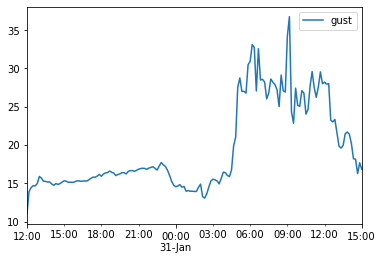

In [86]:
pd.DataFrame({"gust":np.max(speed,axis=(1,2))}, index=times).plot()

print(pd.DataFrame({"gust":np.max(speed,axis=(1,2))}, index=times).sort_values("gust",ascending=False))

In [87]:
aws = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/obs/aws/vic_one_min_gust/2020.csv")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1711: MatplotlibDeprecationWarning: This usage of Quadmesh is deprecated: Parameters meshWidth and meshHeights will be removed; coordinates must be 2D; all parameters except coordinates will be keyword-only.
  collection = mcoll.QuadMesh(


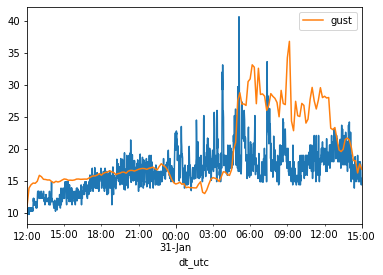

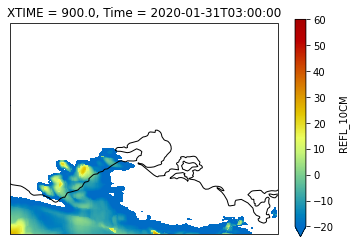

In [107]:
#aws = aws.set_index(pd.DatetimeIndex(aws.dt_utc))
ax=plt.axes()
aws.loc[slice("2020-01-30 12:00","2020-01-31 15:00")].groupby(level=0).max().gust.plot(ax=ax)
pd.DataFrame({"gust":np.max(speed,axis=(1,2))}, index=times).plot(color="tab:orange",ax=ax)

plt.figure()
ax=plt.axes(projection=ccrs.PlateCarree())
p = wrf.getvar(wrflist, "REFL_10CM", timeidx=15).max("bottom_top")

p = xr.where(p==-35,np.nan,p)
p.plot(x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
       vmin=-20,vmax=60)
ax.coastlines()
ax.set_xlim([142.92,146.60])
ax.set_ylim([-39.290,-36.390])
ax.grid()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/pyart/io/grid_io.py:105: UserWarning: Field longitude skipped due to incorrect shape (301, 301)
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/pyart/io/grid_io.py:105: UserWarning: Field latitude skipped due to incorrect shape (301, 301)
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1711: MatplotlibDeprecationWarning: This usage of Quadmesh is deprecated: Parameters meshWidth and meshHeights will be removed; coordinates must be 2D; all parameters except coordinates will be keyword-only.
  collection = mcoll.QuadMesh(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead 

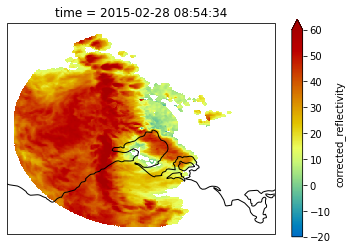

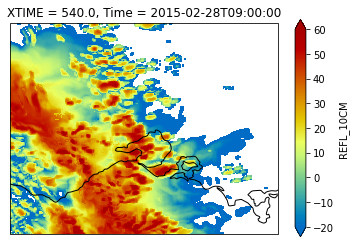

In [58]:
radar = load_radar("2", dt.datetime(2015,2,28,9), radar_t_delta=0)

plt.figure()
ax=plt.axes(projection=ccrs.PlateCarree())
radar.to_xarray().max("z").isel({"time":0}).corrected_reflectivity.plot(x="lon",y="lat",cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
       vmin=-20,vmax=60)
ax.coastlines()
ax.set_xlim([142.92,146.60])
ax.set_ylim([-39.290,-36.390])
ax.grid()

plt.figure()
ax=plt.axes(projection=ccrs.PlateCarree())
p = wrf.getvar(wrflist, "REFL_10CM", timeidx=9).max("bottom_top")

p = xr.where(p==-35,np.nan,p)
p.plot(x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
       vmin=-20,vmax=60)
ax.coastlines()
ax.set_xlim([142.92,146.60])
ax.set_ylim([-39.290,-36.390])
ax.grid()

In [5]:
def read_aws(stn_id, times, state):
    dtypes = {"hd":str, "stn_id":str, "dt_lt":str, "dt_utc":str, "gust":str, "q":str, "#":str}
    df=pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/"+state+"_one_min_gust/HD01D_Data_*"+stn_id+"*.txt")[0],\
        names=["hd","stn_id","dt_lt","dt_utc","gust","q","#"],header=0,dtype=dtypes)
    df["dt_utc"] = pd.to_datetime(df["dt_utc"], format="%Y%m%d%H%M")
    df = df.set_index("dt_utc")
    df["gust"] = pd.to_numeric(df["gust"], errors="coerce")    
    return df.loc[slice(times[0], times[1])]

df = read_aws("086282",[dt.datetime(2015,2,28,0), dt.datetime(2015,3,1,0)],"vic")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/pyart/io/grid_io.py:105: UserWarning: Field longitude skipped due to incorrect shape (301, 301)
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/pyart/io/grid_io.py:105: UserWarning: Field latitude skipped due to incorrect shape (301, 301)
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1711: MatplotlibDeprecationWarning: This usage of Quadmesh is deprecated: Parameters meshWidth and meshHeights will be removed; coordinates must be 2D; all parameters except coordinates will be keyword-only.
  collection = mcoll.QuadMesh(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead 

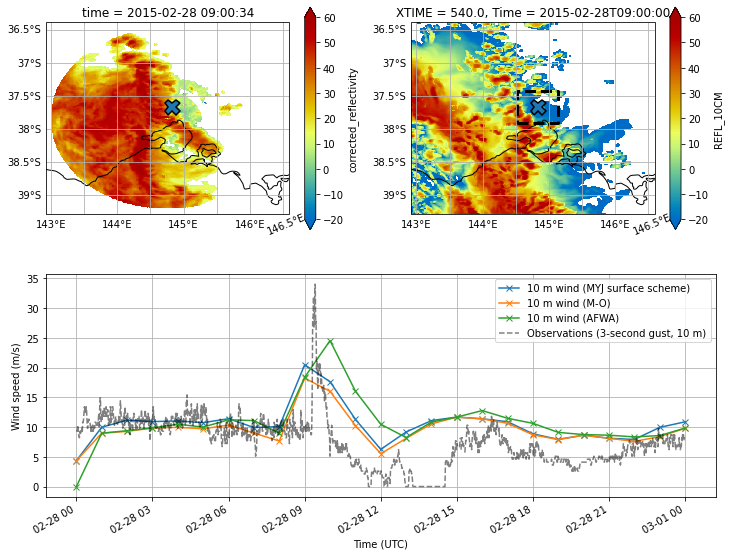

In [14]:
radar = load_radar("2", dt.datetime(2015,2,28,9,2), radar_t_delta=0)
X,Y = wrf.ll_to_xy(wrflist[0],-37.6655,144.8321)
y0,x0 = wrf.xy_to_ll(wrflist[0],X.values-20,Y.values-20).values
y1,x1 = wrf.xy_to_ll(wrflist[0],X.values+20,Y.values+20).values

plt.figure(figsize=[12,10])
ax=plt.subplot2grid((2,2),(0,0),rowspan=1,colspan=1,projection=ccrs.PlateCarree())

radar.to_xarray().max("z").isel({"time":0}).corrected_reflectivity.plot(x="lon",y="lat",cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
       vmin=-20,vmax=60)
ax.coastlines()
ax.set_xlim([142.92,146.60])
ax.set_ylim([-39.290,-36.390])
ax.grid()
g=ax.gridlines(draw_labels=True)
g.top_labels=False
g.right_labels=False
ax.plot(144.8321, -37.6655, marker="X", mfc="tab:blue", markeredgecolor="k", mew=1.5, ms=15)

ax=plt.subplot2grid((2,2),(0,1),rowspan=1,colspan=1,projection=ccrs.PlateCarree())
p = wrf.getvar(wrflist, "REFL_10CM", timeidx=9).max("bottom_top")

p = xr.where(p==-35,np.nan,p)
p.plot(x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
       vmin=-20,vmax=60)
ax.coastlines()
ax.set_xlim([142.92,146.60])
ax.set_ylim([-39.290,-36.390])
ax.grid()
g=ax.gridlines(draw_labels=True)
g.top_labels=False
g.right_labels=False
ax.plot(144.8321, -37.6655, marker="X", mfc="tab:blue", markeredgecolor="k", mew=1.5, ms=15)
ax.plot([x0,x1,x1,x0,x0], [y0,y0,y1,y1,y0],
        color="k",ls="--",lw=3)

ax=plt.subplot2grid((2,2),(1,0),rowspan=1,colspan=2)

p1 = wrf.getvar(wrflist, "U10E", timeidx=wrf.ALL_TIMES, method="cat")
p2 = wrf.getvar(wrflist, "V10E", timeidx=wrf.ALL_TIMES, method="cat")
p=np.sqrt(p1**2+p2**2)
p.attrs=p1.attrs
p.sel({"west_east":slice(X.values-20,X.values+20),"south_north":slice(Y.values-20,Y.values+20)}).\
    max(("west_east","south_north")).plot(ax=ax,marker="x",label="10 m wind (MYJ surface scheme)")

p1 = wrf.getvar(wrflist, "U10", timeidx=wrf.ALL_TIMES, method="cat")
p2 = wrf.getvar(wrflist, "V10", timeidx=wrf.ALL_TIMES, method="cat")
p=np.sqrt(p1**2+p2**2)
p.attrs=p1.attrs
X,Y = wrf.ll_to_xy(wrflist[0],-37.6655,144.8321)
p.sel({"west_east":slice(X.values-20,X.values+20),"south_north":slice(Y.values-20,Y.values+20)}).\
    max(("west_east","south_north")).plot(ax=ax,marker="x",label="10 m wind (M-O)")

p = wrf.getvar(wrflist,"WSPD10MAX", timeidx=wrf.ALL_TIMES, method="cat")
X,Y = wrf.ll_to_xy(wrflist[0],-37.6655,144.8321)
p.sel({"west_east":slice(X.values-20,X.values+20),"south_north":slice(Y.values-20,Y.values+20)}).\
    max(("west_east","south_north")).plot(ax=ax,marker="x",label="10 m wind (AFWA)")

# X,Y = wrf.ll_to_xy(wrflist_d02[0],-37.6655,144.8321)
# p = wrf.getvar(wrflist_d02,"WSPD10MAX", timeidx=wrf.ALL_TIMES, method="cat")
# X,Y = wrf.ll_to_xy(wrflist_d02[0],-37.6655,144.8321)
# p.sel({"west_east":slice(X.values-7,X.values+7),"south_north":slice(Y.values-7,Y.values+7)}).\
#     max(("west_east","south_north")).plot(ax=ax,marker="x",label="Domain 2 (4 km) 10 m wind (AFWA)",color="tab:green",ls="--")

# X,Y = wrf.ll_to_xy(wrflist_d03[0],-37.6655,144.8321)
# p = wrf.getvar(wrflist_d03,"WSPD10MAX", timeidx=wrf.ALL_TIMES, method="cat")
# X,Y = wrf.ll_to_xy(wrflist_d03[0],-37.6655,144.8321)
# p.sel({"west_east":slice(X.values-2,X.values+2),"south_north":slice(Y.values-2,Y.values+2)}).\
#     max(("west_east","south_north")).plot(ax=ax,marker="x",label="Domain 3 (12 km) 10 m wind (AFWA)",color="tab:green",ls=":")

df.gust.plot(ax=ax,ls="--",color="black",alpha=0.5,label="Observations (3-second gust, 10 m)")

ax.grid()
plt.ylabel("Wind speed (m/s)")
plt.xlabel("Time (UTC)")

plt.legend()

plt.savefig("/g/data/eg3/ab4502/figs/wrf_20150228.jpeg",quality=100,bbox_inches="tight")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/pyart/io/grid_io.py:105: UserWarning: Field longitude skipped due to incorrect shape (301, 301)
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/pyart/io/grid_io.py:105: UserWarning: Field latitude skipped due to incorrect shape (301, 301)
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1711: MatplotlibDeprecationWarning: This usage of Quadmesh is deprecated: Parameters meshWidth and meshHeights will be removed; coordinates must be 2D; all parameters except coordinates will be keyword-only.
  collection = mcoll.QuadMesh(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead 

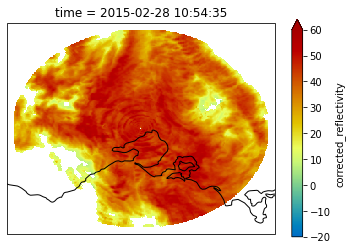

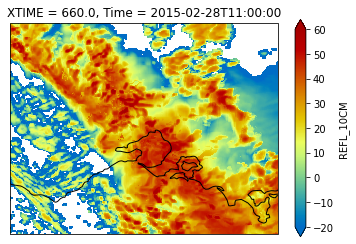

In [60]:
radar = load_radar("2", dt.datetime(2015,2,28,11), radar_t_delta=0)

plt.figure()
ax=plt.axes(projection=ccrs.PlateCarree())
radar.to_xarray().max("z").isel({"time":0}).corrected_reflectivity.plot(x="lon",y="lat",cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
       vmin=-20,vmax=60)
ax.coastlines()
ax.set_xlim([142.92,146.60])
ax.set_ylim([-39.290,-36.390])
ax.grid()

plt.figure()
ax=plt.axes(projection=ccrs.PlateCarree())
p = wrf.getvar(wrflist, "REFL_10CM", timeidx=11).max("bottom_top")

p = xr.where(p==-35,np.nan,p)
p.plot(x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
       vmin=-20,vmax=60)
ax.coastlines()
ax.set_xlim([142.92,146.60])
ax.set_ylim([-39.290,-36.390])
ax.grid()

In [50]:
print(x0,x1,y0,y1)

144.51629886259803 145.13934568481397 -37.91298079425164 -37.421909915219985


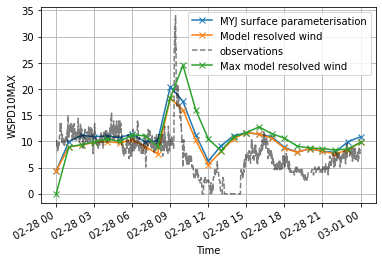

/jobfs/34335419.gadi-pbs/ipykernel_871153/1066073219.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax=plt.gca(projection=ccrs.PlateCarree())
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1548: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to inc

(-39.29, -36.39)

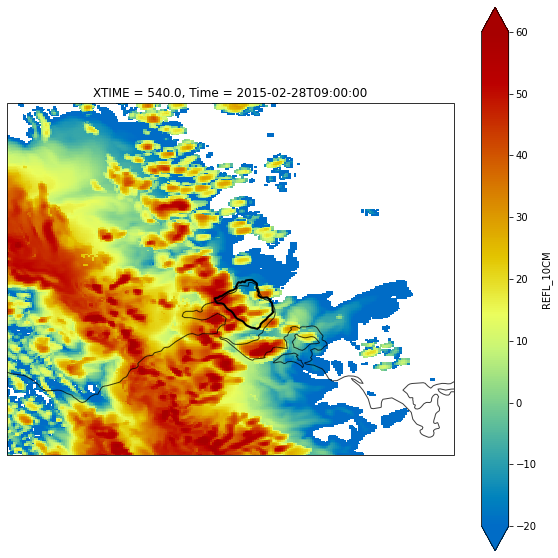

In [64]:
plt.figure(figsize=[10,10])
ax=plt.gca(projection=ccrs.PlateCarree())

p = wrf.getvar(wrflist,"W_DN_MAX", timeidx=10, method="cat")
xr.plot.contour(p,x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),colors="k",linewidths=2,
       vmin=0,vmax=30,levels=[-10],ax=ax)

p = wrf.getvar(wrflist,"WSPD10MAX", timeidx=10, method="cat")
xr.plot.contour(p,x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),colors="k",linewidths=2,
       vmin=0,vmax=30,levels=[20],ax=ax)

p = wrf.getvar(wrflist, "REFL_10CM", timeidx=9).max("bottom_top")
p = xr.where(p==-35,np.nan,p)
p.plot(x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
       vmin=-20,vmax=60,ax=ax)
ax.coastlines(color="k",alpha=0.75)
ax.set_xlim([142.92,146.60])
ax.set_ylim([-39.290,-36.390])